# Odour Distance Discrimination Analysis

This notebook accompanies the manuscript *"Mice discriminate odour source distance via sub-sniff temporal features of odour plumes"* by Alina Cristina Marin, Julia J Harris, Debanjan Dasgupta, Andrew Erskine, Tom Warner, Andreas T Schaefer, and Tobias Ackels.

It enables reproduction of panels from all main figures presented in the paper.



In [1]:
import os
import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from scipy import signal
import copy
import pickle
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr

In [2]:
# Set target directory 
target_directory = 'C://Users//tobia//Dropbox//Manuscripts//Distance paper (marin et al)//Data//for repository//data_files' # change to your target directory
os.chdir(target_directory) 

## Figure 1: Mice can discriminate between near and far odour sources.

In [3]:
# Load data
matD2_1 = scipy.io.loadmat('behaviour//StageD2_1_data.mat')
matD2_2 = scipy.io.loadmat('behaviour//StageD2_2_data.mat')
matD2_3 = scipy.io.loadmat('behaviour//StageD2_3_data.mat')
matD2_4 = scipy.io.loadmat('behaviour//StageD2_4_data.mat')
expts = [matD2_1, matD2_2, matD2_3, matD2_4]
expts_stage = ['D2', 'D2_2', 'D2_3', 'D2_4']

# Load lick data
file_to_read = open("behaviour//StageD2_3_lickdata.pickle", "rb")
mousedfs = pickle.load(file_to_read)
file_to_read.close()

# Extract mouse names and sort by their schedules
mat = expts[0]
mouse_names = []
for m in mat['mouseNames']:
    mouse_names.append(m[0][0])
Group1 = [0,1,2,4,5,6,7,8,9,10,11]
Group2 = [3,12,13,14,15,16,17,18,19,20,21,22,23]

In [4]:
# Extract rewarded sequences
bsize = 100 # block size
alldf1 = pd.DataFrame() # for group 1
alldf2 = pd.DataFrame() # for group 2

for mat,count in tqdm(zip(expts, range(np.shape(expts)[0]))):
    rewarded_1 = []
    rewarded_2 = []
    for i in range(0,int(mat['rewarded_array'][0,:].shape[0]/200)):
        rewarded_1 = np.append(rewarded_1,mat['rewarded_array'][0,:200])
        rewarded_2 = np.append(rewarded_2,mat['rewarded_array'][22,:200])
    df1 = pd.DataFrame(data=mat['correct_array'][Group1].T, columns=np.array(mouse_names)[Group1])
    df1.insert(0,'Rewarded', rewarded_1)
    df2 = pd.DataFrame(data=mat['correct_array'][Group2].T, columns=np.array(mouse_names)[Group2])
    df2.insert(0,'Rewarded', rewarded_2)
    
    # Add experiment number
    e1 = np.ones(df1.shape[0])*count
    df1.insert(0, 'Expt', e1)
    e2 = np.ones(df2.shape[0])*count
    df2.insert(0, 'Expt', e2)
    
    # Append to the main df for the group
    alldf1 = pd.concat([alldf1,df1],ignore_index=True)
    alldf2 = pd.concat([alldf2,df2],ignore_index=True)
# Add the OVERALL block number
Block = []
for i in range(0,int(alldf1.shape[0]/bsize)):
    Block = np.append(Block, np.ones(bsize)*i)
alldf1.insert(1,'Block_'+str(bsize)+'trials', Block)

Block = []
for i in range(0,int(alldf2.shape[0]/bsize)):
    Block = np.append(Block, np.ones(bsize)*i)
alldf2.insert(1,'Block_'+str(bsize)+'trials', Block)

# blocks where performance is stable, after learning
chosen_blocks = range(25,35)

4it [00:00, 272.30it/s]


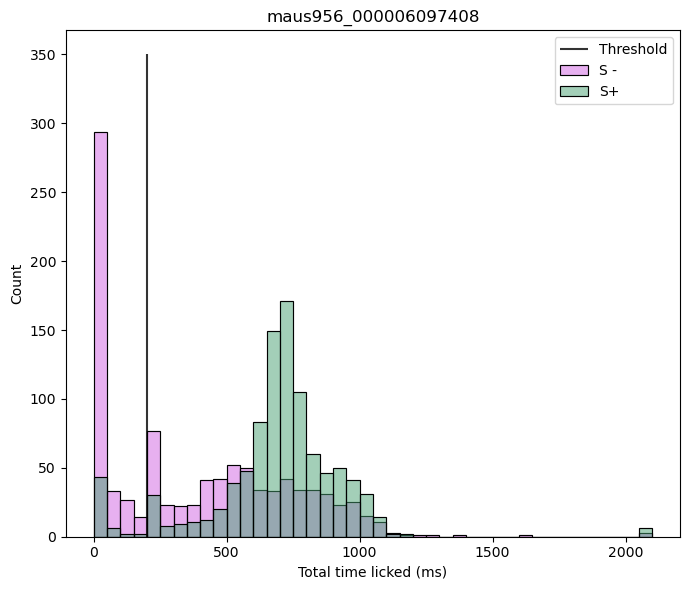

In [5]:
# Figure 1E: Distribution of total time licked for example mouse

lick_treshold = 200*20 # 200ms*20 because one trial is ~60000 long, or 3s
pal = sns.diverging_palette(145, 300, l=60, n=2)
m=18 # other well-performing mice are 0,1,3,14,7
tmousedf = mousedfs[m]
mousedf = tmousedf.groupby(by='Trial').mean().iloc[:,[0,1]]

fig,ax = plt.subplots(figsize=(7,6))
g = sns.histplot(data=mousedf, x='Total_time_licked', hue='Rewarded',palette=pal, hue_order=[1,0], binwidth=1000)
g.vlines(x=lick_treshold, ymin=0, ymax=350, color='k', alpha=0.8)
g.set_xticks([0,10000,20000,30000, 40000])
g.set_xticklabels([0,500,1000,1500,2000])
g.set_xlabel('Total time licked (ms)')
g.set_title(mouse_names[m])
g.legend(['Threshold','S -', 'S+'])
plt.tight_layout()

In [6]:
# Calculate ratios for all mice vs many shuffles fo each mouse

bin1_ratios = []; bin2_ratios = []
bin1_ratios_shuf = []; bin2_ratios_shuf = []
nrshufs = 500
for m, tmousedf in tqdm(zip(range(0,24),mousedfs)):
    mousedf = tmousedf.groupby(by='Trial').mean().iloc[:,[0,1]]
    # CR/Miss window
    bin1_splus = mousedf[(mousedf['Rewarded']==1) & (mousedf['Total_time_licked']<lick_treshold)].shape[0]
    bin1_smin = mousedf[(mousedf['Rewarded']==0) & (mousedf['Total_time_licked']<lick_treshold)].shape[0]
    # Hit/FA window
    bin2_splus = mousedf[(mousedf['Rewarded']==1) & (mousedf['Total_time_licked']>lick_treshold)].shape[0]
    bin2_smin = mousedf[(mousedf['Rewarded']==0) & (mousedf['Total_time_licked']>lick_treshold)].shape[0]
    bins = []
    ratios =[]
    bins = [bin1_splus, bin1_smin, bin2_splus, bin2_smin]
    ratios = [bin1_splus/bin1_smin, bin2_splus/bin2_smin]
    bin1_ratios.append(bin1_smin/bin1_splus)
    bin2_ratios.append(bin2_smin/bin2_splus)

    bin1_ratios_shuf_m = []
    bin2_ratios_shuf_m = []

    for i in range(0,nrshufs):
        rewarded_shuf = np.array(mousedf['Rewarded'])
        np.random.shuffle(rewarded_shuf)
        unrewarded_shuf = rewarded_shuf*(-1)+1
        # CR/Miss window
        bin1_splus_shuf = mousedf[rewarded_shuf & (mousedf['Total_time_licked']<lick_treshold)].shape[0]
        bin1_smin_shuf = mousedf[unrewarded_shuf & (mousedf['Total_time_licked']<lick_treshold)].shape[0]
        # Hit/FA window
        bin2_splus_shuf = mousedf[rewarded_shuf & (mousedf['Total_time_licked']>lick_treshold)].shape[0]
        bin2_smin_shuf = mousedf[unrewarded_shuf & (mousedf['Total_time_licked']>lick_treshold)].shape[0]
    
        bins_shuf = [bin1_splus_shuf, bin1_smin_shuf, bin2_splus_shuf, bin2_smin_shuf]
        ratios_shuf = [
        bin1_smin_shuf / bin1_splus_shuf if bin1_splus_shuf != 0 else np.nan,
        bin2_smin_shuf / bin2_splus_shuf if bin2_splus_shuf != 0 else np.nan
        ]
        bin1_ratios_shuf_m.append(ratios_shuf[0])
        bin2_ratios_shuf_m.append(ratios_shuf[1])

    bin1_ratios_shuf.append(bin1_ratios_shuf_m)
    bin2_ratios_shuf.append(bin2_ratios_shuf_m)

# Calculate the fraction of shuffles smaller than the bin1_ratio for each mouse. Close to 0 is better
f =[]
for m in range(0,len(mouse_names)):
    thisf = 0
    for s in range(0,nrshufs):
        if bin1_ratios_shuf[m][s] > bin1_ratios[m]:
            thisf = thisf+1
    f.append(thisf/nrshufs)    

24it [00:12,  1.95it/s]


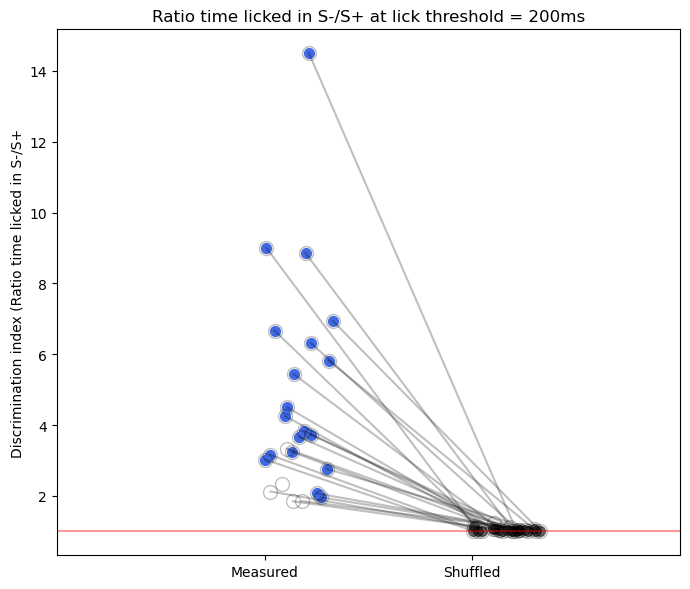

In [7]:
#Figure 1F: Discrimination index

jitter = np.random.random_sample((len(mouse_names),))/3
fig,ax = plt.subplots(figsize=(7,6))
for i in range(0,len(mouse_names)):
    if f[i]<0.01:
        ax.scatter([1+jitter[i]],[bin1_ratios[i]], c='royalblue', s=50)
        ax.scatter([2+jitter[i]],[np.mean(bin1_ratios_shuf[i])], c='k', alpha=0.5, s=50)
    ax.plot([1+jitter[i],2+jitter[i]],[bin1_ratios[i], np.mean(bin1_ratios_shuf[i])], c='k',alpha=0.25, marker='o', fillstyle='none', markersize=10)

ax.set_xlim([0,3])
ax.hlines(y=1, xmin=0, xmax=3, color='r',alpha=0.4)
ax.set_title('Ratio time licked in S-/S+ at lick threshold = 200ms')
ax.set_ylabel('Discrimination index (Ratio time licked in S-/S+')
ax.set_xticks([1,2])
ax.set_xticklabels(['Measured', 'Shuffled'])
plt.tight_layout()

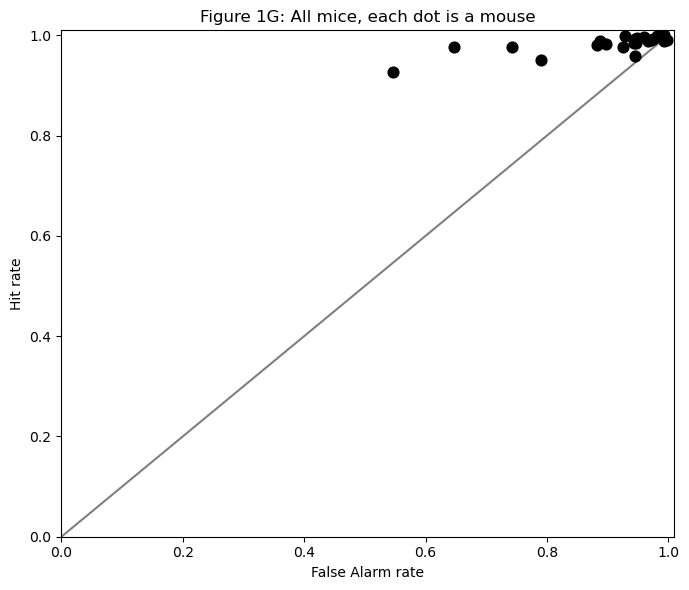

In [8]:
#Figure 1G: Hit rate over false alarm rate

fig, ax = plt.subplots(figsize=(7,6))
for df, group in zip([alldf1, alldf2], [1,2]):
    for m in range(df.shape[1]-3):
        ax.scatter(np.mean(1-df[df['Block_100trials'].isin(chosen_blocks)].groupby(by=['Rewarded', 'Block_100trials']).mean().iloc[:,1:].T[0].iloc[m,:]),
                       np.mean(df[df['Block_100trials'].isin(chosen_blocks)].groupby(by=['Rewarded', 'Block_100trials']).mean().iloc[:,1:].T[1].iloc[m,:]),
                       color='k', s=60, alpha=1)
ax.plot([0,1],[0,1],'k-', alpha=0.5)
ax.set_title('Figure 1G: All mice, each dot is a mouse')
ax.set_xlim([0,1.01])
ax.set_ylim([0,1.01])
ax.set_xlabel('False Alarm rate')
ax.set_ylabel('Hit rate')
plt.tight_layout()

## Figure 2: Odour plume structure varies reliably with distance and sub-sniff features are the most informative.

In [6]:
# Load plume data
temp_plumes_rec = scipy.io.loadmat('plumes//all_plumes_recorded.mat')
plumes_recorded = temp_plumes_rec['allplumes']

# Assign labels for recorded plumes
distance_labels_plumes_rec = np.repeat([80, 60, 40, 30], 90)
labels_rec = distance_labels_plumes_rec.reshape(4,90)

temp_plumes_rep = scipy.io.loadmat('plumes//all_plumes_reproduced.mat')
temp2_plumes_rep = temp_plumes_rep['plumes']
plumes_reproduced = np.zeros([160,4000])
for i in range(0,160):
    plumes_reproduced[i]=scipy.signal.resample(temp2_plumes_rep[i],4000)

# Assign labels for reproduced plumes
distance_labels_plumes_rep = np.repeat([80, 60, 40, 30], 40)
labels_rep = distance_labels_plumes_rep.reshape(4,40)    

In [17]:
# Configuration for both conditions
conditions = {
    'recorded': {
        'plumes': plumes_recorded,
        'n': 360,
        'label_array': distance_labels_plumes_rec,
        'align': True,
        'height': 0.01,
        'prominence': 0.01
    },
    'reproduced': {
        'plumes': plumes_reproduced,
        'n': 160,
        'label_array': distance_labels_plumes_rep,
        'align': False,
        'height': 0.05,
        'prominence': 0.1
    }
}

# Time windows
time_windows = [500 * i for i in range(1, 11)]
results = {}

for name, cfg in conditions.items():
    # Aligned for recorded plumes
    if cfg['align']:
        plume_arrivals = [next((i for i, x in enumerate(plumes_recorded) if x), None) for plumes_recorded in cfg['plumes']]
        aligned = np.zeros((cfg['n'], 9000))
        for p, start in enumerate(plume_arrivals):
            aligned[p, :len(cfg['plumes'][p][start:])] = cfg['plumes'][p][start:]
        plumes = aligned
    else:
        plumes = np.array(cfg['plumes'])

    features = {
        'Number_peaks': [],
        'Max_peak': [],
        'Max_prominence': [],
        'Mean': [],
        'Std': [],
        'Variance': [],
        'Skewness': [],
        'Kurtosis': []
    }

    for t in time_windows:
        num_peaks, max_peaks, max_proms = [], [], []
        tmeans, tstds, tvars, tskews, tkurts = [], [], [], [], []

        for plume in tqdm(plumes, desc=f"[{name.upper()}] Time window {t}"):
            p = plume[:t]
            peaks, props = signal.find_peaks(p, height=cfg['height'], prominence=cfg['prominence'])

            num_peaks.append(len(peaks))
            max_peaks.append(np.max(props['peak_heights']) if len(props['peak_heights']) > 0 else 0)
            max_proms.append(np.max(props['prominences']) if len(props['prominences']) > 0 else 0)
            tmeans.append(np.mean(p))
            tstds.append(np.std(p))
            tvars.append(np.var(p))
            tskews.append(stats.skew(p))
            tkurts.append(stats.kurtosis(p))

        features['Number_peaks'].append(num_peaks)
        features['Max_peak'].append(max_peaks)
        features['Max_prominence'].append(max_proms)
        features['Mean'].append(tmeans)
        features['Std'].append(tstds)
        features['Variance'].append(tvars)
        features['Skewness'].append(tskews)
        features['Kurtosis'].append(tkurts)

    # Assemble DataFrames
    dfs = []
    for i, t in enumerate(time_windows):
        df = pd.DataFrame({
            'Time_window': np.full(cfg['n'], t),
            'Distance': cfg['label_array'],
            'Number_peaks': features['Number_peaks'][i],
            'Max_peak': features['Max_peak'][i],
            'Max_prominence': features['Max_prominence'][i],
            'Mean': features['Mean'][i],
            'Std': features['Std'][i],
            'Variance': features['Variance'][i],
            'Skewness': features['Skewness'][i],
            'Kurtosis': features['Kurtosis'][i]
        })
        dfs.append(df)

    results[name] = pd.concat(dfs, ignore_index=True)

# Output DataFrames
plumes_rec_df = results['recorded']
plumes_rep_df = results['reproduced']

[REPRODUCED] Time window 5000: 100%|██████████| 160/160 [00:00<00:00, 640.41it/s]


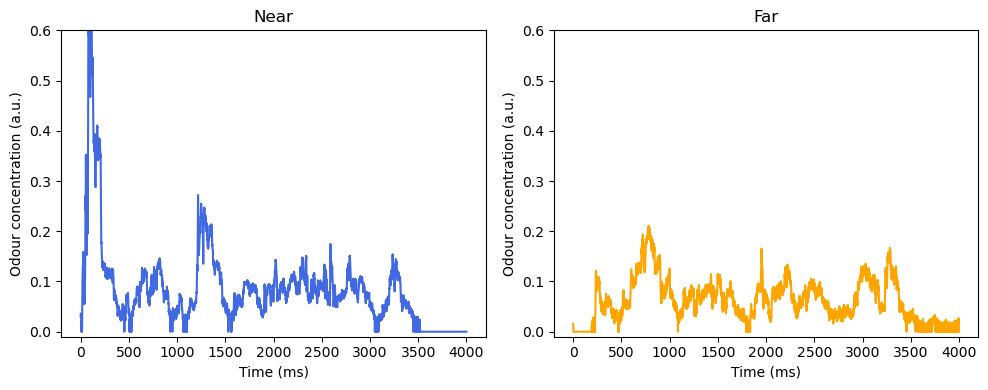

In [11]:
# Figure 2B: Example of plumes recorded in the wind tunnel from near and far

explumes = [158, 36]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colors = ['royalblue', 'orange']

for i, (ax, title, p) in enumerate(zip(axes, ['Near', 'Far'], explumes)):
    ax.plot(aligned[p][:4000] / 0.097, c=colors[i])
    ax.set_ylim([-0.01, 0.6])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Odour concentration (a.u.)')
    ax.set_title(title)
plt.tight_layout()

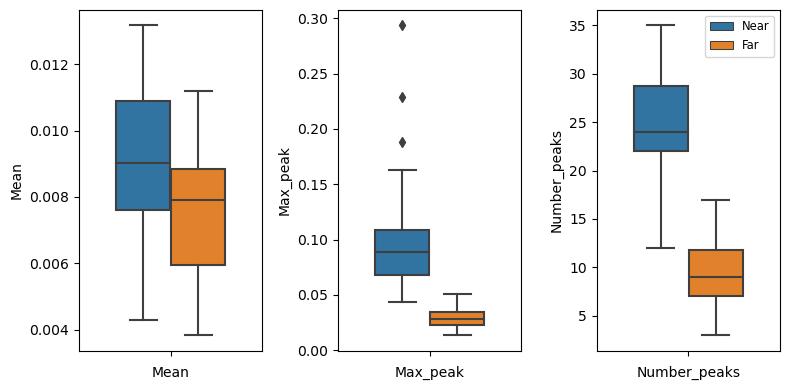

In [12]:
# Figure 2C: Quantification of near and far plume features recorded in the wind tunnel

fig, axes = plt.subplots(1,3, figsize=(8,4))
features = ['Mean', 'Max_peak', 'Number_peaks']#, 'Std']
for ax, feature in zip(axes, features):
    ax= sns.boxplot(data = plumes_rec_df[(plumes_rec_df['Distance'].isin([30,80]))&(plumes_rec_df['Time_window']==5000)], hue='Distance', x='Time_window', y =feature, ax = ax, width=0.6)
    ax.set_xlabel(feature)
    ax.set_xticklabels([])
    ax.get_legend().remove()
handles, legend_labels = axes[0].get_legend_handles_labels()
axes[-1].legend(handles, ['Near', 'Far'], fontsize='small')
plt.tight_layout()

Exception in thread Thread-8 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\tobia\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\tobia\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\tobia\anaconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\tobia\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tobia\anaconda3\Lib\site-packages\joblib\externals\l

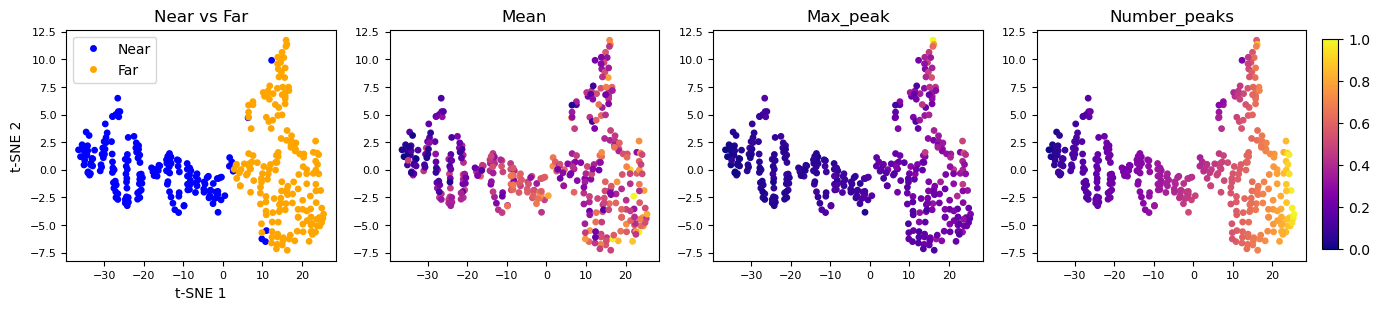

In [13]:
# Figure 2D-E: t-SNE plot of odour plume features

# Extract 5-second window data
df_5s = plumes_rec_df[plumes_rec_df['Time_window'] == 5000].copy()
df_5s['Group'] = [0 if i < 180 else 1 for i in range(len(df_5s))]

# Define feature matrix and group labels
feature_cols = ['Mean', 'Max_peak', 'Number_peaks',  'Max_prominence', 'Std', 'Variance', 'Kurtosis', 'Skewness']
X = df_5s[feature_cols].values
group_labels = df_5s['Group'].values

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

fig, axes = plt.subplots(1, 3 + 1, figsize=(16, 3))

colors = ['blue' if g == 0 else 'orange' for g in group_labels]
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=15)
axes[0].set_title('Near vs Far')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].tick_params(axis='both', labelsize=8)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Near', markerfacecolor='blue', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Far', markerfacecolor='orange', markersize=6)
]
axes[0].legend(handles=legend_elements, loc='upper left')

vmin = df_5s[feature_cols].min().min()
vmax = df_5s[feature_cols].max().max()
cmap = matplotlib.colormaps.get_cmap('plasma')

for i, feature in enumerate(feature_cols[:3]):
    color_vals = df_5s[feature]
    ax = axes[i + 1]
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_vals, cmap=cmap, s=15)
    ax.set_title(feature)
    ax.tick_params(axis='both', labelsize=8)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap), cax=cbar_ax)
plt.subplots_adjust(right=0.9, wspace=0.2)
plt.show()

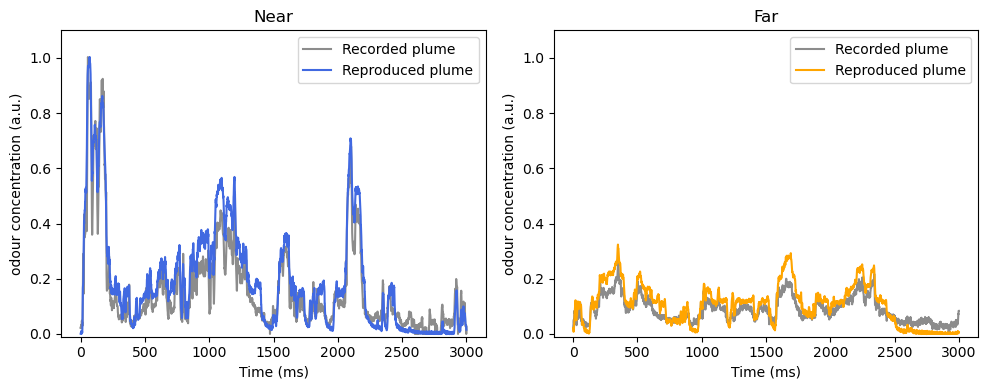

In [5]:
# Figure 2G: Examples of near and far reproduced plumes

recorded_reprod_plumes = scipy.io.loadmat('plumes//all_plumes_recorded_reproduced.mat')
recorded_aligned = recorded_reprod_plumes['aligned_wt_plumes']
reproduced = recorded_reprod_plumes['reprod_plumes']

explumes = [159, 36]
fig, axes = plt.subplots(1,2, figsize=(10,4))
for ax, title, p in zip(axes, ['Near', 'Far'], explumes):
    ax.plot(recorded_aligned[recorded_reprod_plumes['reprod_plumes_ids'][0][p]][:3000] / 0.097, c='gray', alpha=0.9)
    if p == explumes[0]:
        color = 'royalblue'  # plume 0
    else:
        color = 'orange'     # plume 1
    ax.plot(reproduced[p][65:3065] / 0.54, c=color, alpha=1)
    ax.set_ylim([-0.01, 1.1])
    ax.legend(['Recorded plume', 'Reproduced plume'])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('odour concentration (a.u.)')
    ax.set_title(title)
plt.tight_layout()

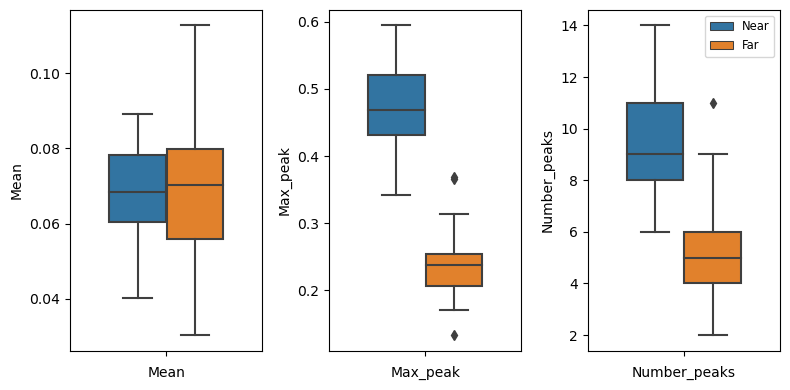

In [15]:
# Figure 2H: Quantification of near and far plume features reproduced with tODD

fig, axes = plt.subplots(1,3, figsize=(8,4))
features = ['Mean', 'Max_peak', 'Number_peaks']#, 'Std']
for ax, feature in zip(axes, features):
    ax= sns.boxplot(data = plumes_rep_df[(plumes_rep_df['Distance'].isin([30,80]))&(plumes_rep_df['Time_window']==5000)], hue='Distance', x='Time_window', y =feature, ax = ax, width=0.6)
    ax.set_xlabel(feature)
    ax.set_xticklabels([])
    ax.get_legend().remove()
handles, legend_labels = axes[0].get_legend_handles_labels()
axes[-1].legend(handles, ['Near', 'Far'], fontsize='small')
plt.tight_layout()

## Figure 3: Responses of MTCs to temporally structured odour plumes recorded from different distances.

In [3]:
# Load df/f traces
tracesdf = pd.read_pickle('imaging//Traces_df_all.pkl')

# Load respiration data for each mouse
respiration1 = scipy.io.loadmat('imaging//Respiration_M1.mat')['respiration']
respiration2 = scipy.io.loadmat('imaging//Respiration_M2.mat')['respiration']
respiration3 = scipy.io.loadmat('imaging//Respiration_M3.mat')['respiration']

# Scale respiration traces to [-1,1], centered at 0
resp_scaled1 = (respiration1 - np.mean(respiration1))/np.max(respiration1-np.mean(respiration1))
resp_scaled2 = (respiration2 - np.mean(respiration2))/np.max(respiration2-np.mean(respiration2))
resp_scaled3 = (respiration3 - np.mean(respiration3))/np.max(respiration3-np.mean(respiration3))

times = scipy.io.loadmat('imaging//time_vectors.mat')
time_im = times['time_imaging']
time_resp = times['time_resp']

C:\Users\tobia\AppData\Local\Temp\ipykernel_33560\1329646236.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\tobia\AppData\Local\Temp\ipykernel_33560\1329646236.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


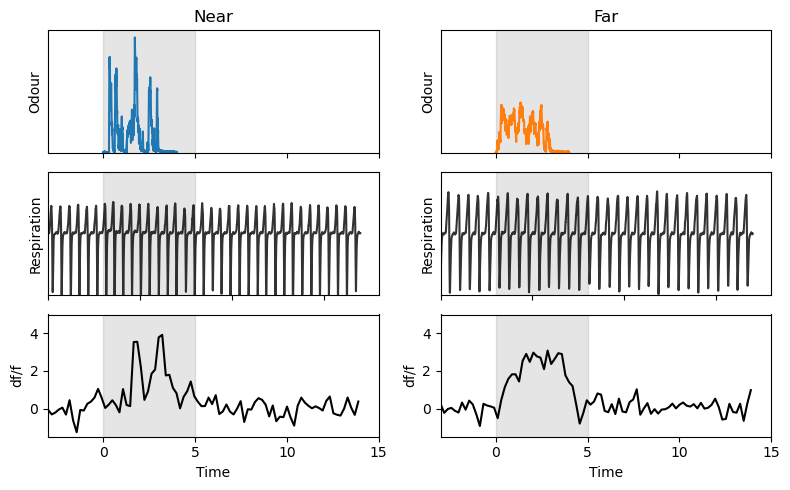

In [7]:
# Figure 3C: Example trials in response to near and far plumes

ex_plumes = [158, 35]  # example plumes
ex_resp_trials = [203, 128] # example trials
cell = 17 # example cells [mouse, cell]
mouse = 2
pal_4dist = [sns.color_palette()[0], sns.color_palette('pastel')[0], sns.color_palette('pastel')[1], sns.color_palette()[1]]

fig, axes = plt.subplots(3,2,figsize=(8,5))
plt.tight_layout()
for ax,plume,title,colour in zip(axes[0],ex_plumes, ['Near', 'Far'],[pal_4dist[0],pal_4dist[3]]):
    ax.plot(plumes_reproduced[plume], color=colour)
    ax.set_ylim([0,0.5])
    ax.set_xlim([-3000,15000])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_title(title)
    ax.fill_between([0,5000],[-1,-1],3, color='k', alpha=0.1)
    ax.set_ylabel('Odour')
for ax,trial in zip(axes[1],ex_resp_trials):
    ax.plot(resp_scaled2[trial], color='k', alpha=0.8)
    ax.set_xlim([0,18000])
    ax.set_xticklabels([])
    ax.set_ylim([-0.5,0.5])
    ax.set_yticks([])
    ax.fill_between([3000,8000],[-1,-1],3, color='k', alpha=0.1)
    ax.set_ylabel('Respiration')
for ax,trial in zip(axes[2],ex_resp_trials):
    sns.lineplot(data=tracesdf[(tracesdf['Mouse'] == mouse) & (tracesdf['Cell'] == cell) & (tracesdf['Trial'] == trial)],
                    x='Time', y='df/f', ax=ax, color='k')    
    # ax= sns.lineplot(data = tracesdf[(tracesdf['Trial']==trial)&(tracesdf['Mouse']==mouse)&(tracesdf['Cell']==cell)], x='Time', y='df/f', ax=ax, color='k')
    ax.fill_between([0,5],[-2,-2],10, color='k', alpha=0.1)
    ax.set_xlim([-3,15])
    ax.set_ylim([-1.5,5])
    plt.tight_layout()


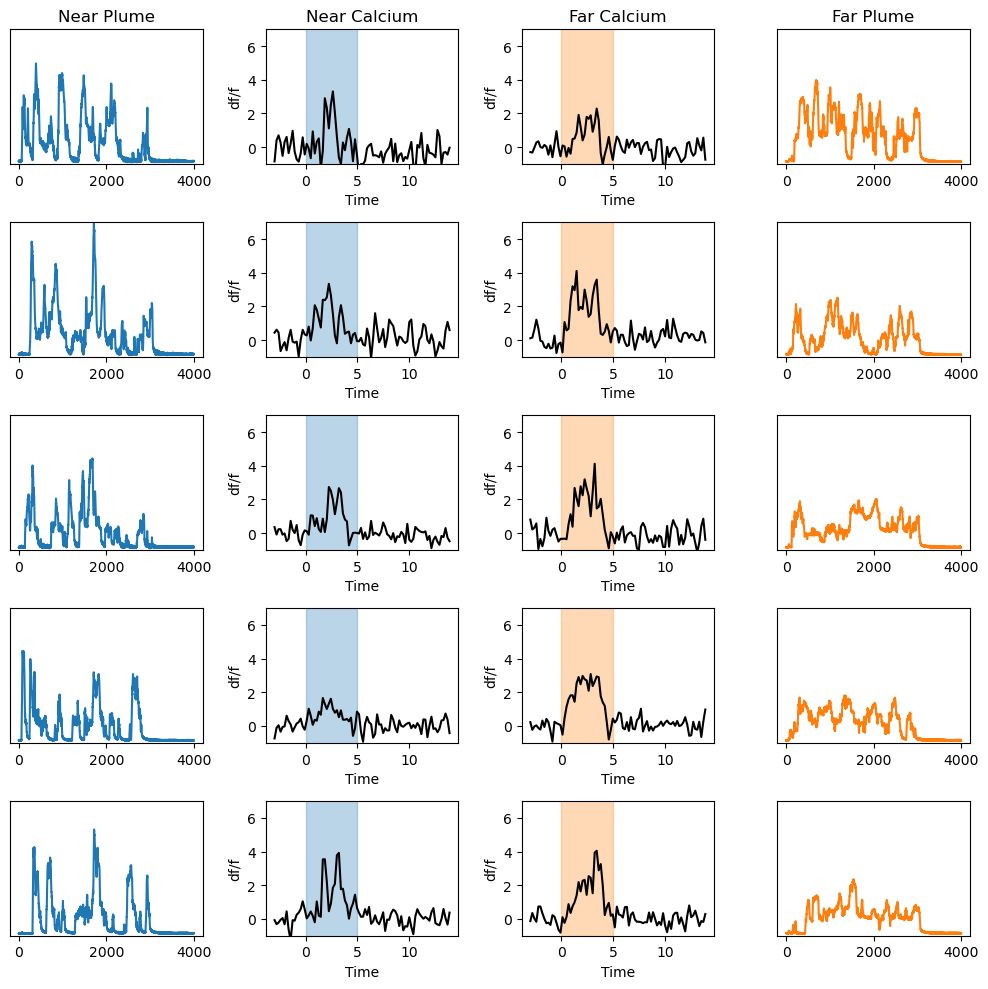

In [8]:
# Figure 3D: Responses to all near and far plumes from an example cell

mouse = 2
cell = 17

plumesF = plumes_reproduced[:40, :]   # Far plumes
plumesN = plumes_reproduced[120:, :]  # Near plumes

fig, axes = plt.subplots(5, 4, figsize=(10, 10))
axes = axes.reshape(-1, 4)

indices = [0, 1, 2, 35, 38]
titles = ['Near', 'Far', 'Near', 'Far', 'Far']

for row_idx, (i, title, ax_row) in enumerate(zip(indices, titles, axes)):

    pn = 121 + i
    pf = i + 1

    tns = tracesdf[(tracesdf['Mouse'] == mouse) & (tracesdf['Cell'] == cell) &
                   (tracesdf['Odour'] == 1) & (tracesdf['Plume'] == pn)]['Trial'].astype(int).unique()
    tfs = tracesdf[(tracesdf['Mouse'] == mouse) & (tracesdf['Cell'] == cell) &
                   (tracesdf['Odour'] == 1) & (tracesdf['Plume'] == pf)]['Trial'].astype(int).unique()

    tn = tns[0] if len(tns) > 0 else None
    tf = tfs[0] if len(tfs) > 0 else None

    ax_row[0].plot(plumesN[i], color=pal_4dist[0])
    ax_row[3].plot(plumesF[i], color=pal_4dist[3])
    ax_row[0].set_ylim([-0.01, 0.6])
    ax_row[3].set_ylim([-0.01, 0.6])
    ax_row[0].set_yticks([])
    ax_row[3].set_yticks([])

    if tn is not None:
        sns.lineplot(data=tracesdf[(tracesdf['Mouse'] == mouse) & (tracesdf['Cell'] == cell) & (tracesdf['Trial'] == tn)],
                     x='Time', y='df/f', ax=ax_row[1], color='k')
    if tf is not None:
        sns.lineplot(data=tracesdf[(tracesdf['Mouse'] == mouse) & (tracesdf['Cell'] == cell) & (tracesdf['Trial'] == tf)],
                     x='Time', y='df/f', ax=ax_row[2], color='k')

    ax_row[1].set_ylim([-1, 7])
    ax_row[2].set_ylim([-1, 7])
    ax_row[1].fill_between([0, 5], [-2, -2], 10, color=pal_4dist[0], alpha=0.3)
    ax_row[2].fill_between([0, 5], [-2, -2], 10, color=pal_4dist[3], alpha=0.3)
    if row_idx == 0:
        ax_row[0].set_title("Near Plume")
        ax_row[1].set_title("Near Calcium")
        ax_row[2].set_title("Far Calcium")
        ax_row[3].set_title("Far Plume")
plt.tight_layout()

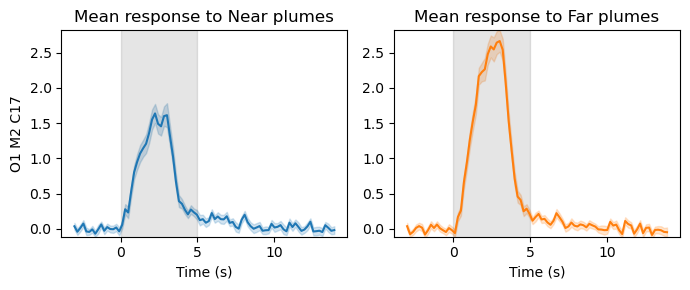

In [9]:
# Figure 3E: Averaged responses to all near and far plumes for an example distance-sensitive cells

fig,ax = plt.subplots(1,2, figsize=(7,3))
for m,c,o in zip([2],[17],[1]):

    t=tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)].groupby(['Time']).mean().index
    d30 = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)].groupby(['Time']).mean()['df/f']
    d30e = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)].groupby(['Time']).sem()['df/f']
    ax[0].plot(t,d30, c=pal_4dist[0])
    ax[0].fill_between(t,d30-d30e,d30+d30e, alpha=0.2, color=pal_4dist[0])
    ax[0].set_title('Mean response to Near plumes')

    d80 = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==80)].groupby(['Time']).mean()['df/f']
    d80e = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==80)].groupby(['Time']).sem()['df/f']
    ax[1].plot(t,d80,c=pal_4dist[3])
    ax[1].fill_between(t,d80-d80e,d80+d80e, alpha=0.2,color=pal_4dist[3])
    ax[1].set_title('Mean response to Far plumes')

    ax[0].set_ylabel('O'+str(o)+' M'+str(m)+' C'+str(c))
    for a in ax:
        a.set_ylim([min(d30-d30e),max(max(d30+d30e),max(d80+d80e))])
   
    ax[0].fill_between([0,5],[-2,-2],10, color='k', alpha=0.1)
    ax[1].fill_between([0,5],[-2,-2],10, color='k', alpha=0.1)
ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)') 
plt.tight_layout()

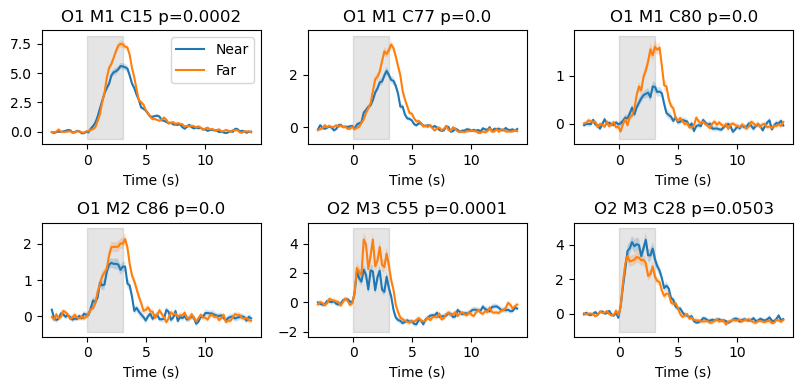

In [10]:
# Figure 3F: Examples of distance-sensitive cells

ms =[1,1,1,2,3,3]
cs = [15,77,80,86,55,28]
os = [1,1,1,1,2,2]
fig, axes = plt.subplots(2,3, figsize=(8,4))

for m,c,o,ax in zip(ms,cs,os,np.ravel(axes)):
    
    t=tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)].groupby(['Time']).mean().index
    d30 = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)].groupby(['Time']).mean()['df/f']
    d30sem = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)].groupby(['Time']).sem()['df/f']

    d80 = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==80)].groupby(['Time']).mean()['df/f']
    d80sem = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==80)].groupby(['Time']).sem()['df/f']
    
    ax.plot(t,d30)
    ax.plot(t,d80)
    ax.fill_between(t,d30-d30sem,d30+d30sem, alpha=0.2)
    ax.fill_between(t,d80-d80sem,d80+d80sem, alpha=0.2)
    
    d30m = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==30)&(tracesdf['Time']>0)&(tracesdf['Time']<5)].groupby(['Trial']).mean()['df/f']
    d80m = tracesdf[(tracesdf['Mouse']==m)&(tracesdf['Cell']==c)&(tracesdf['Odour']==o)&(tracesdf['Distance']==80)&(tracesdf['Time']>0)&(tracesdf['Time']<5)].groupby(['Trial']).mean()['df/f']
    p = scipy.stats.ttest_ind(d30m,d80m)[1]

    ymin, ymax = ax.get_ylim()
    ax.fill_between([0, 3], ymin, ymax, color='k', alpha=0.1)
    ax.set_title('O'+str(o)+' M'+str(m)+' C'+str(c)+ ' p='+str(round(p,4)))
    ax.set_xlabel('Time (s)')

    if c==15:
        ax.legend(['Near', 'Far'])
plt.tight_layout()

## Figure 4: Population activity and linear discriminant analysis of MTC responses.

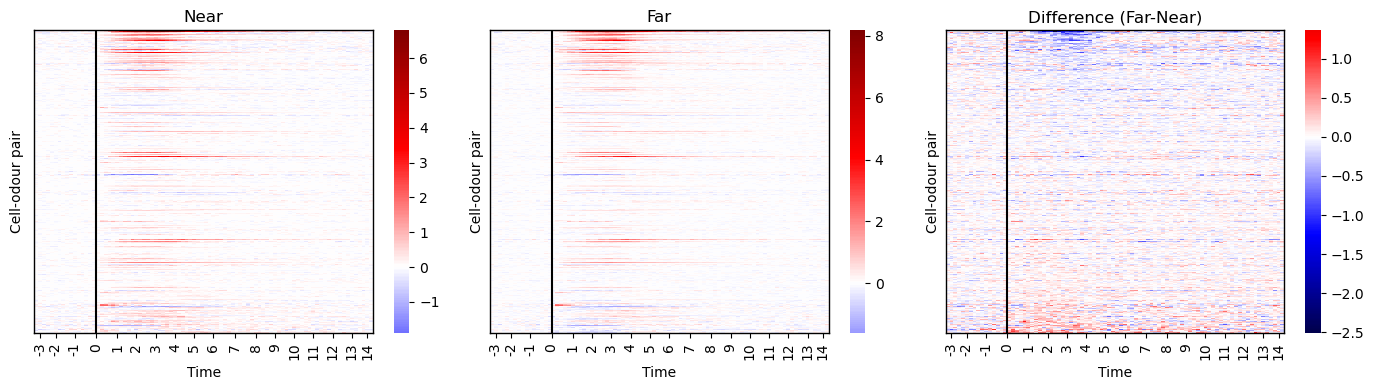

In [11]:
# Figure 4A: Calcium transients as colour maps for averaged responses to near (left) and far (middle) plumes and for the difference between the two (right) for all cell-odour pairs

# Organize data 
O1table = pd.pivot_table(tracesdf[(tracesdf['Odour']==1)&(tracesdf['Distance'].isin([30,80]))], values = 'df/f', columns = ['Distance','Time'], index = ['Odour','Mouse', 'Cell'])
O2table = pd.pivot_table(tracesdf[(tracesdf['Odour']==2)&(tracesdf['Distance'].isin([30,80]))], values = 'df/f', columns = ['Distance','Time'], index = ['Odour','Mouse', 'Cell'])
COPtable = pd.concat([O1table, O2table])

def distributed_integer_ticks(df, anchor_x=16, k_min=-3, k_max=15):
    time_vals = df.columns.get_level_values("Time").astype(float).to_numpy()
    rounded   = np.round(time_vals).astype(int)
    pos, lab = [], []
    for k in range(k_min, k_max + 1):
        idx = np.flatnonzero(rounded == k)
        if idx.size:
            pos.append(idx.mean() + 0.5)
            lab.append(k)
    if 0 in lab:
        zero_shift = anchor_x - pos[lab.index(0)]
        pos = np.array(pos) + zero_shift
    ncols = df.shape[1]
    mask  = (pos >= 0) & (pos <= ncols)
    return pos[mask], np.array(lab)[mask]

# Sorted by difference between Near and Far, in ascending order (Far>Near at the top, Near>Far at the bottom)
DifTable = COPtable.loc[:, 30] - COPtable.loc[:, 80]
orderDif = DifTable.iloc[:, 16:42].mean(axis=1).sort_values().index

fig, ax = plt.subplots(1, 3, figsize=(14,4), sharey=True)
colormap = "seismic"

mats   = [
    COPtable.loc[orderDif][30],
    COPtable.loc[orderDif][80],
    COPtable.loc[orderDif][30] - COPtable.loc[orderDif][80],
]
titles = ["Near", "Far", "Difference (Far-Near)"]

for a, mat, title in zip(ax, mats, titles):
    sns.heatmap(mat, cmap=colormap, center=0, ax=a)
    a.set_title(title)
    a.set_ylabel('Cell-odour pair')
    a.axvline(x=16, color="k")
    a.set_yticklabels([])
    a.tick_params(axis="y", length=0)
    pos, lab = distributed_integer_ticks(mat, anchor_x=16, k_min=-3, k_max=15)
    a.set_xticks(pos)
    a.set_xticklabels(lab)
    for spine in a.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
plt.tight_layout()

In [12]:
# Figure 4C: Responses to near vs responses to far plumes plotted as mean df/f response for all trials

w = 5 # response window length (s)
Traces_resp_window = tracesdf[(tracesdf['Time']<w)&(tracesdf['Time']>0)]
Mean_resp = Traces_resp_window.groupby(by=['Mouse', 'Cell', 'Trial']).mean().reset_index()
# transform to cell-odour pairs 
df1 = pd.pivot_table(Mean_resp[Mean_resp['Odour']==1], values = 'df/f', index = ['Plume', 'Distance'], columns = ['Mouse', 'Cell'])
df2 = pd.pivot_table(Mean_resp[Mean_resp['Odour']==2], values = 'df/f', index = ['Plume', 'Distance'], columns = ['Mouse', 'Cell'])

# transform to array
data_array1 = df1.sort_values(by='Plume').to_numpy()
data_array2 = df2.sort_values(by='Plume').to_numpy()
distances1 = np.array(df1.sort_values(by='Plume').index.droplevel(0))
distances2 = np.array(df2.sort_values(by='Plume').index.droplevel(0))
distances = distances1
data_array = np.hstack([data_array1, data_array2])

In [13]:
# Determine distance-senstive cells by running an ANOVA for each cell between 4 distances
sig_cops = []
sig_ps = []
pas = []
pairs = [[30,40], [30,60], [30,80], [40,60], [40,80], [60,80]]

for o in [1,2]:
    for m in [1,2,3]:
        for c in range(0,int(Mean_resp[(Mean_resp['Odour']==o)&(Mean_resp['Mouse']==m)]['Cell'].max())+1):
            d30 = Mean_resp[(Mean_resp['Odour']==o)&
                            (Mean_resp['Mouse']==m)&
                            (Mean_resp['Cell']==c)&
                            (Mean_resp['Distance']==30)]['df/f'].to_numpy()
            d40 = Mean_resp[(Mean_resp['Odour']==o)&
                            (Mean_resp['Mouse']==m)&
                            (Mean_resp['Cell']==c)&
                            (Mean_resp['Distance']==40)]['df/f'].to_numpy()   
            d60 = Mean_resp[(Mean_resp['Odour']==o)&
                            (Mean_resp['Mouse']==m)&
                            (Mean_resp['Cell']==c)&
                            (Mean_resp['Distance']==60)]['df/f'].to_numpy()
            d80 = Mean_resp[(Mean_resp['Odour']==o)&
                            (Mean_resp['Mouse']==m)&
                            (Mean_resp['Cell']==c)&
                            (Mean_resp['Distance']==80)]['df/f'].to_numpy()
    
            F,pa = stats.f_oneway(d30,d40,d60,d80)
            pas.append(pa)
    
p_values_df = pd.DataFrame(pas, columns=['p_value'])

# Apply Benjamini-Hochberg FDR correction
rejected, pvals_corrected, _,_ = multipletests(p_values_df['p_value'], alpha=0.05, method='fdr_bh')
p_values_df['pval_corrected'] = pvals_corrected
p_values_df['rejected'] = rejected

reset_ids=[]
for i in p_values_df[p_values_df['rejected']].index:
    if i<len(p_values_df)/2:
        reset_ids.append(i)
    else:
        reset_ids.append(i-len(p_values_df)/2)

print('Number of distance sensitive cells after False Discovery Rate (FDR) correction: ' +str(len(p_values_df[p_values_df['rejected']].index)))
print('Of which for Odour 1: ' +str(sum(p_values_df[p_values_df['rejected']].index<len(p_values_df)/2)))
print('Of which for Odour 2: ' +str(sum(p_values_df[p_values_df['rejected']].index>len(p_values_df)/2-1)))    

Number of distance sensitive cells after False Discovery Rate (FDR) correction: 13
Of which for Odour 1: 11
Of which for Odour 2: 2


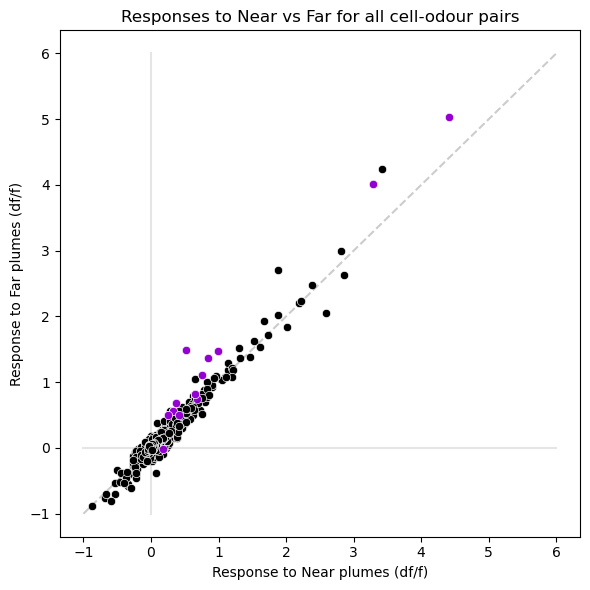

In [14]:
# Figure 4C: Responses to near vs responses to far plumes

d1 = pd.pivot_table(Traces_resp_window[Traces_resp_window['Odour']==1], values = 'df/f', columns = ['Distance'], index = ['Mouse', 'Cell'])
d2 = pd.pivot_table(Traces_resp_window[Traces_resp_window['Odour']==2], values = 'df/f', columns = ['Distance'], index = ['Mouse', 'Cell'])

fig,ax = plt.subplots(figsize=(6,6))
ax.plot([-1,6],[-1,6],'k--', alpha=0.2)
ax.plot([0,0],[-1,6],'k', alpha=0.1)
ax.plot([-1,6],[0,0],'k', alpha=0.1)
ax = sns.scatterplot(data=d1, x=30, y=80, color='k', ax=ax)
ax = sns.scatterplot(data=d2, x=30, y=80, color='k', ax=ax)
ax = sns.scatterplot(data = d1.iloc[reset_ids[:11],:], x=30, y = 80, ax=ax, color='darkviolet')
ax = sns.scatterplot(data = d2.iloc[reset_ids[11:]], x=30, y = 80, ax=ax, color='darkviolet')
ax.set_xlabel('Response to Near plumes (df/f)')
ax.set_ylabel('Response to Far plumes (df/f)')
ax.set_title('Responses to Near vs Far for all cell-odour pairs')
plt.tight_layout()

## Figure 5: Features of the temporal structure of odour plumes involved in distance discrimination.

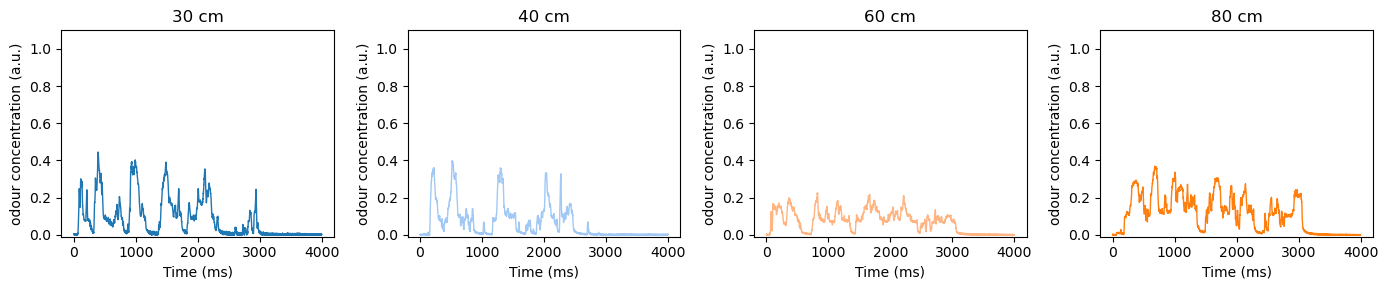

In [15]:
# Figure 5A: Example plumes recorded from four different distances (30 cm, 40 cm, 60 cm and 80 cm)

# Load data
recorded_reprod_plumes = scipy.io.loadmat('plumes//all_plumes_recorded_reproduced.mat')
recorded_aligned = recorded_reprod_plumes['aligned_wt_plumes']
reproduced = recorded_reprod_plumes['reprod_plumes']
traces_features = pd.read_pickle("imaging//imaging_traces_plume_features.pkl")

explumes = [120, 80, 40, 0]
fig, axes = plt.subplots(1,4, figsize=(14,3))
for ax, title, p, color in zip(axes, ['30 cm', '40 cm', '60 cm', '80 cm'], explumes, pal_4dist):
    ax.plot(reproduced[p], c=color, alpha=1, linewidth=1)
    ax.set_ylim([-0.01, 1.1])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('odour concentration (a.u.)')
    ax.set_title(title)
plt.tight_layout()

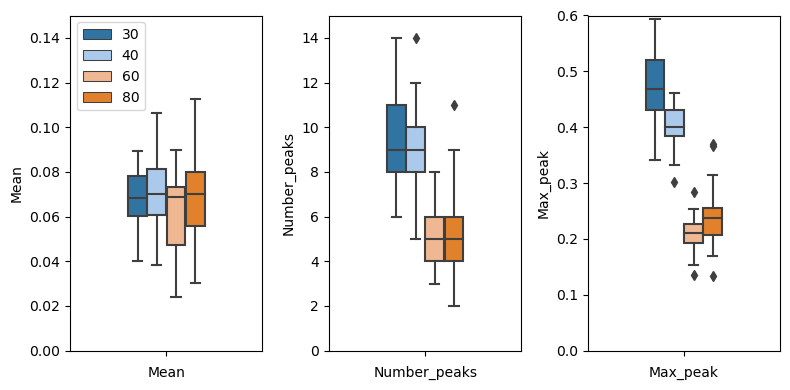

In [18]:
# Figure 5B: Quantification of plume features for 4 distances 

fig, axes = plt.subplots(1,3, figsize=(8,4))
features = ['Mean', 'Number_peaks', 'Max_peak']
for ax, feature in zip(axes, features):
    ax= sns.boxplot(data = plumes_rep_df[plumes_rep_df['Time_window']==5000], hue='Distance', x='Time_window', y =feature, ax = ax, width=0.4,palette=pal_4dist)
    ax.set_xlabel(feature)
    ax.set_xticklabels([])
    ax.legend()
if ax == axes[0]:
    handles, legend_labels = ax.get_legend_handles_labels()
else: 
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()

axes[0].set_ylim([0,0.15])
axes[1].set_ylim([0,15])
axes[2].set_ylim([0,0.6])
plt.tight_layout()

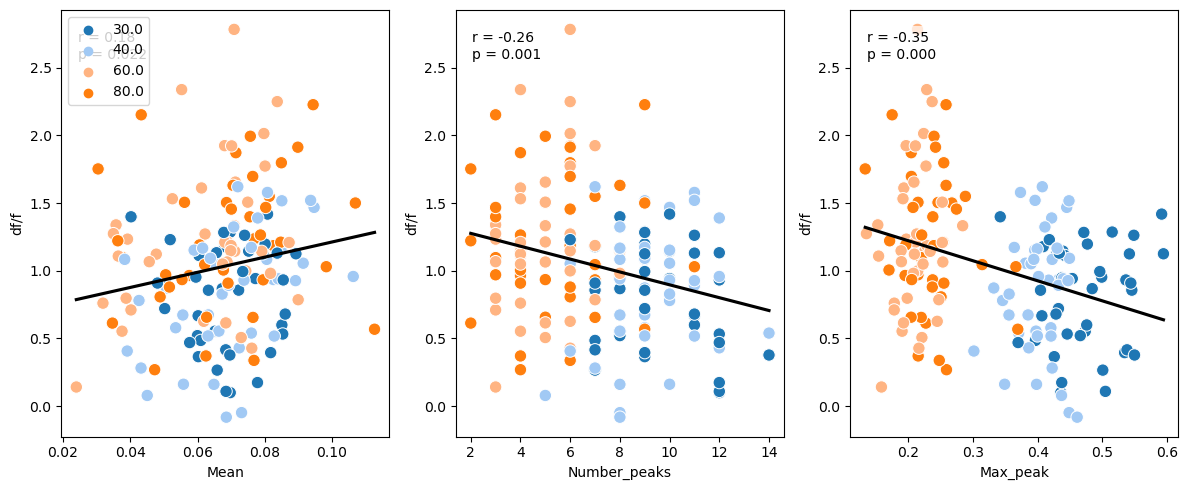

In [19]:
# Figure 5C: Response of an example distance-sensitive ROI plotted against individual features of the odour stimulus

fig, axes = plt.subplots(1, 3, figsize=[12, 5])
data = traces_features[(traces_features['Mouse'] == 2) & (traces_features['Cell'] == 17) & (traces_features['Odour'] == 1)]
grouped = data.groupby('Trial').mean()

for feature, ax in zip(features, axes):
    x_vals = grouped[feature]
    y_vals = grouped['df/f']
    r, p = pearsonr(x_vals, y_vals)

    sns.regplot(data=grouped, x=feature, y='df/f', ax=ax, scatter=False, ci=None, color='k')
    sns.scatterplot(data=grouped, x=feature, y='df/f', hue='Distance', palette=pal_4dist, ax=ax, s=80)

    ax.text(0.05, 0.95, f"r = {r:.2f}\np = {p:.3f}", transform=ax.transAxes,
            verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    ax.legend()
if ax == axes[0]:
    handles, legend_labels = ax.get_legend_handles_labels()
else: 
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()    
plt.tight_layout()

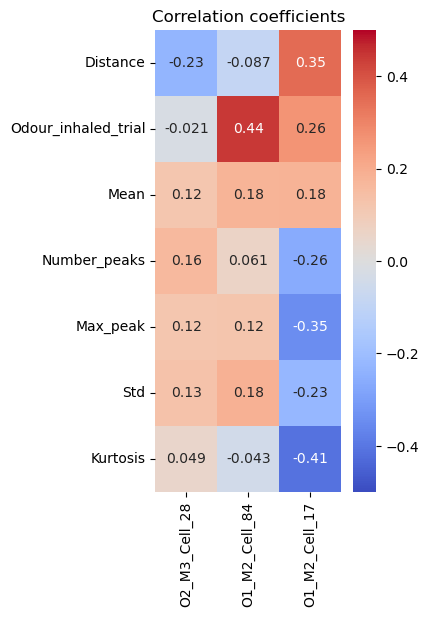

In [20]:
# Figure 5D: Correlation coefficients to distance and other stimulus features

Corr = pd.DataFrame()
for o in [1,2]:
    for m in range(1,4):
        ThisMouse = traces_features[(traces_features['Mouse']==m)&(traces_features['Odour']==o)]
    
        for c in range(0,int(ThisMouse['Cell'].max()+1)):
            Celldf = ThisMouse[ThisMouse['Cell']==c].groupby(by=['Trial']).mean()
            ThisCorr = Celldf.loc[:,['Norm df/f','Distance','Plume_integral','Odour_inhaled_trial', 'Mean','Number_peaks','Max_peak',
                             'Max_prominence','Std','Peaks_to_mean', 'Variance', 'Kurtosis', 'Skewness', 'First_peak_time', 'First_peak_height']].corr()['Norm df/f']
            ThisCorr.name = 'O'+str(o)+'_M'+str(m)+'_Cell_'+str(c)
            Corr = pd.concat([Corr, ThisCorr], axis=1)

fig, ax = plt.subplots(figsize=(3,6))
features4plot = ['Distance', 'Odour_inhaled_trial', 'Mean','Number_peaks', 'Max_peak', 'Std', 'Kurtosis']
ax= sns.heatmap(Corr.loc[features4plot,
                        [ 'O2_M3_Cell_28', 'O1_M2_Cell_84', 'O1_M2_Cell_17',]],
            vmin=-0.5, vmax = 0.5, cmap='coolwarm', annot=True, ax=ax)
ax.set_title('Correlation coefficients');

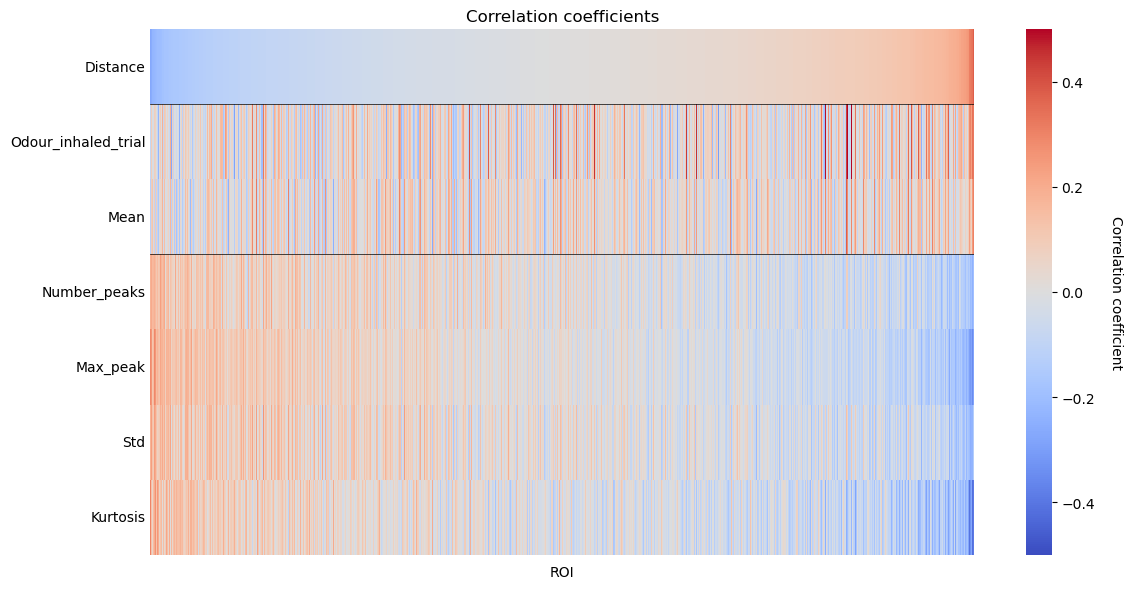

In [21]:
# Figure 5E: Heatmap of correlation coefficients for all ROIs

fig, ax = plt.subplots(figsize=(12,6))
ax=sns.heatmap(Corr.loc[features4plot,:].sort_values(by='Distance', axis=1), vmin=-0.5, vmax = 0.5, cmap='coolwarm', ax=ax)
ax.set_title('Correlation coefficients')
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('ROI')
ax.axhline(y=1, color='black', linewidth=0.5)
ax.axhline(y=3, color='black', linewidth=0.5)
# Set rotated colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Correlation coefficient', rotation=270, labelpad=20)
plt.tight_layout()